<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/marcoteran/deeplearning/blob/master/notebooks/1.2_machinelearning_imbalanceddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab" title="Abrir y ejecutar en Google Colaboratory"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/marcoteran/deeplearning/blob/master/notebooks/1.2_machinelearning_imbalanceddata.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Abrir en Kaggle" title="Abrir y ejecutar en Kaggle"/></a>
  </td>
</table>

### Ejemplo de código
# Sesión 02: Manejo de clases desbalanceadas con la librería Python ImbLearn
## Deep Learning y series de tiempo

**Name:** Marco Teran
**E-mail:** marco.teran@usa.edu.co

[Website](http://marcoteran.github.io/),
[Github](https://github.com/marcoteran),
[LinkedIn](https://www.linkedin.com/in/marcoteran/).
___

## Carcaterísticas del Dataset: Credit Card Fraud Detection

En este ejercicio, se utilizará Python y el conjunto de datos [Credit Card Fraud Detection de Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud):
* Este conjunto de datos tiene un tamaño de 66 MB y se expande a 150 MB después de descomprimirlo
* El archivo creditcard.csv consta de 285,000 filas y 31 columnas (características)
* Excepto por las columnas Time y Amount (el importe de la transacción), la información de las características es privada y se nombran como V1, V2, V3, etc
* Las clases están etiquetadas como 0 y 1, correspondiendo a "transacción normal" o "fraude"
Debido a la desigualdad del conjunto de datos, hay muy pocas muestras etiquetadas como fraude. El enfoque se centra en aplicar diversas estrategias para mejorar los resultados, en lugar de elegir el modelo y ajustarlo en exceso.

Se dará prioridad a aplicar diversas estrategias para mejorar los resultados a pesar del desequilibrio de clases, en lugar de enfocarse en la elección y configuración del modelo.

#### Requerimientos técnicos
- Se necesitará Python 3.6 en el sistema, y se recomienda tener instalada la plataforma Anaconda para trabajar en una Notebook Jupyter
- Es necesario instalar la librería **Imbalanced Learn**

Instalación de la librería:

In [1]:
#!pip install -U imbalanced-learn
# conda install -c conda-forge imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

# Analisis exploratorio de los datos

Se debe realizar un análisis exploratorio para comprobar si hay desequilibrio entre las clases.

### Descargar los datos
Descarga de Kaggle en https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [3]:
from pathlib import Path
import pandas as pd
import urllib.request
import zipfile

def load_creditcard_data():
    zip_file_path = Path("data/archive.zip")
    if not zip_file_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/marcoteran/deeplearning/raw/master/data/archive.zip"
        urllib.request.urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path) as zip_file:
        zip_file.extract("creditcard.csv", path="data")
    return pd.read_csv(Path("data/creditcard.csv"))

Después de importar las librerías necesarias, se carga el dataframe con pandas y se observan las primeras filas.

In [4]:
df = load_creditcard_data() # read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly4

HTTPError: HTTP Error 404: Not Found

Es importante verificar la cantidad de filas del dataframe y la cantidad de filas de cada clase.

In [ ]:
df.shape # Comprobación secundaria del tamaño del dataframe

In [ ]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

En este caso, el dataframe consta de 284,807 filas y sólo 492 filas pertenecen a la clase minoritaria de casos de fraude, lo que representa el 0.17% de las muestras.

In [ ]:
# Si no tienes una idea intuitiva de lo desequilibradas que están estas dos clases, vamos a lo visual
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frecuencia por número de observación")
plt.xlabel("Clase")
plt.ylabel("Número de observaciones");

Es necesario tener en cuenta que la línea roja que representa los casos de fraude es mínima debido a que son muy pocas muestras.

In [ ]:
normal_df = df[df.Class == 0] # guardar las observaciones de normal_df en un df separado
fraud_df = df[df.Class == 1]  # hacer lo mismo con los fraudes

In [ ]:
# Trama de transacciones de alto valor
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins, alpha=1, normed=True, label='Normal')
plt.hist(fraud_df.Amount, bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Cantidad por porcentaje de transacciones (transacciones superiores a \$200+)")
plt.xlabel("Cantidad de las transacciones (USD)")
plt.ylabel("Porcentaje de transacciones (%)");
plt.show()

In [ ]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, normed=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Porcentaje de transacciones por hora")
plt.xlabel("Tiempo de transacción medido desde la primera transacción del conjunto de datos (horas)")
plt.ylabel("Porcentaje de transacciones (%)");
#plt.hist((df.Time/(60*60)),bins)
plt.show()

In [ ]:
plt.scatter((normal_df.Time/(60*60)), normal_df.Amount, alpha=0.6, label='Normal')
plt.scatter((fraud_df.Time/(60*60)), fraud_df.Amount, alpha=0.9, label='Fraud')
plt.title("Cantidad de la transacción por hora")
plt.xlabel("Tiempo de transacción medido desde la primera transacción del conjunto de datos (horas)")
plt.ylabel("Cantidad (USD)")
plt.legend(loc='upper right')
plt.show()

Separamos los datos de entrenamiento de las etiquetas:

In [ ]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

A continuación reduciremos un conjunto de datos a 2 dimensiones para poder visualizarlos. Utilizaremos técnicas de reducción de dimensionalidad para lograr este objetivo y luego representaremos los datos en un gráfico de dispersión bidimensional. Esto nos permitirá tener una mejor comprensión de la estructura de los datos y de las relaciones entre las variables

In [ ]:
# Reducir el conjunto de datos a 2 dimensiones para visualizarlos
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)

fig, ax = plt.subplots(1, 2, figsize= (15,5))

ax[0].scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label="Normal", alpha=0.2)
ax[0].scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label="Fraude", alpha=0.2)
ax[0].set_title('PCA del conjunto de datos original')
ax[0].legend()

ax[1] = sns.countplot(y)
ax[1].set_title('Número de observaciones por clase')

### Creación del módelo
Se representa una función llamada `run_model` que implementa un modelo de **regresión logística** utilizando la biblioteca Scikit-learn en Python.
* La regresión logística es un tipo de algoritmo de aprendizaje supervisado que se utiliza comúnmente para la clasificación de datos.
* El modelo utiliza una función ***sigmoide*** para asignar una probabilidad a cada clase y se entrena mediante la maximización de la función de verosimilitud.

Se utilizan los siguientes parámetros para ajustar el modelo:
- `C=1.0`, `penalty='l2'`, `random_state=1` y `solver="newton-cg"`.

El parámetro **C** controla la fuerza de regularización del modelo, mientras que **penalty** especifica el tipo de regularización a aplicar, y **solver** especifica el algoritmo de optimización utilizado para ajustar el modelo.

In [ ]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Modelo sin balancear

Entrenamos el modelo aún sin balancear las clases:

In [ ]:
model = run_model(X_train, X_test, y_train, y_test)

A continuación, se define una función que muestra la matriz de confusión y un informe de clasificación:
- La matriz de confusión es una herramienta común para evaluar el rendimiento de un modelo de clasificación
- El informe de clasificación proporciona métricas adicionales, como la precisión, la exhaustividad y la puntuación F1, para evaluar el rendimiento del modelo.

In [ ]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Clase verdadera')
    plt.xlabel('Clase prevista')
    plt.show()
    print (classification_report(y_test, pred_y))

In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se presenta la matriz de confusión, y en particular se enfoca en la clase 2, que es la que se quiere detectar. Se observan 51 falsos negativos y 97 verdaderos positivos, lo que resulta en un recall de 0.66, un valor que se desea mejorar. Aunque los resultados de la columna de f1-score son buenos, no deben ser engañosos, ya que reflejan una realidad parcial. Es importante destacar que el modelo no es capaz de detectar correctamente los casos de fraude.

# Estrategias para el tratamiento de datos desbalanceados

##  1. Estrategia: Penalización para compensar

En el proceso de construcción del modelo de Regresión logística, se incorporará un parámetro adicional denominado `weight = balanced`. Esto permitirá que el algoritmo equilibre la clase minoritaria durante el entrenamiento.
* Al establecer el parámetro **weight** en ***balanced***, el modelo asigna pesos diferentes a cada clase durante el entrenamiento para equilibrar la clase minoritaria
* Se asignan pesos inversamente proporcionales a la frecuencia de las clases en los datos de entrenamiento.
Esto significa que las observaciones de la clase minoritaria tendrán un **peso mayor** que las observaciones de la clase mayoritaria durante el entrenamiento, lo que permite que el modelo preste más atención a la clase minoritaria y reduzca el sesgo hacia la clase mayoritaria.

In [ ]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2', random_state=1, solver="newton-cg", class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

Corremos el modelo luego de aplicar la estrategia

In [ ]:
model = run_model_balanced(X_train, X_test, y_train, y_test)

Validamos los resultados

In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Al incorporar esta modificación, se ha obtenido una significativa mejora en la detección de casos fraudulentos, específicamente en la clase 2, que representa si hubo fraude. Se han acertado 137 muestras y se han fallado en 11, obteniendo un recall de 0.93. Se destaca que la inclusión de este parámetro no ha afectado negativamente el f1-score, sino que en realidad ha mejorado la capacidad del modelo para detectar casos de fraude. Es importante tener en cuenta que al aumentar los falsos positivos, se etiquetarán más muestras como fraudulentas cuando en realidad no lo son, pero esto es preferible a fallar en detectar los casos reales de fraude.

##  2. Estrategia: Subsampling en la clase mayoritaria

Por otro lado, se utilizará un algoritmo para reducir la clase mayoritaria. Este algoritmo se asemeja al **k-nearest neighbor** y permite seleccionar cuáles muestras eliminar. En este caso, se ha reducido significativamente de 199.020 a solo 688 muestras de la clase cero (la mayoría), con las cuales se entrenará el modelo.
* NearMiss es un algoritmo de submuestreo utilizado para abordar el problema de desequilibrio de clases en los conjuntos de datos de entrenamiento.
* Se basa en la idea de seleccionar las instancias de la clase mayoritaria que están más cercanas a las instancias de la clase minoritaria y eliminarlas para equilibrar las clases.
* Hay tres versiones diferentes de NearMiss:
    - **NearMiss-1** selecciona las instancias de la clase mayoritaria más cercanas al centro de la clase minoritaria
    - **NearMiss-2** selecciona las instancias de la clase mayoritaria más lejanas a la clase minoritaria
    - **NearMiss-3** selecciona las instancias de la clase mayoritaria que tienen la menor distancia media a sus k instancias más cercanas de la clase minoritaria.

`sampling_strategy` se refiere a la proporción de instancias de la clase mayoritaria que se mantendrán después del submuestreo en relación con el número de instancias de la clase minoritaria.

In [ ]:
us = NearMiss(sampling_strategy=0.5, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_sample(X_train, y_train)

print ("Distribución de las etiquetas de clase antes del resampling {}".format(Counter(y_train)))
print ("Distribución de las etiquetas de clase despues del  resampling {}".format(Counter(y_train_res)))

Corremos el modelo luego de aplicar la estrategia

In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

Validamos los resultados

In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se obtiene un buen resultado con un recall de 0.93 aunque aumentaron los falsos positivos.

## 3. Estrategia: Random Oversampling de la clase minoritaria

Se crean muestras sintéticas de la clase minoritaria utilizando `RandomOverSampler`. `RandomOverSampler` es una técnica de sobremuestreo para tratar el problema de desequilibrio de clases en los datos:
* Duplica o triplica aleatoriamente las instancias de la clase minoritaria hasta que se equilibre con la clase mayoritaria.
* Esto puede aumentar el riesgo de sobreajuste y generar datos sintéticos no realistas

Los parámetros principales son:
- "sampling_strategy", que determina la proporción deseada de instancias de la clase minoritaria
- "random_state" para controlar la reproducibilidad
- "fit_resample" para realizar el sobremuestreo y la adaptación del modelo en una sola llamada de función.

In [ ]:
os =  RandomOverSampler(sampling_strategy=0.5)
X_train_res, y_train_res = os.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

El número de muestras de fraude aumenta de 344 a 99.510.

Se corre nuevamente el modelo

In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

Se validan los resultados

In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se alcanza un recall de 0.89 para la clase 2 y los falsos positivos son 838.

# Estrategia: Combinamos resampling con Smote-Tomek
# 4 Combinando Smote tomek

Se utiliza la técnica de aplicar simultáneamente un algoritmo de subsampling y otro de oversampling al dataset. Se aplica SMOTE para oversampling y Tomek para undersampling. La técnica busca puntos vecinos cercanos y agrega puntos en línea recta entre ellos para oversampling, y quita los de distinta clase que sean nearest neighbor y deja ver mejor el decisión boundary para undersampling.

In [ ]:
os_us = SMOTETomek(ratio=0.5)
X_train_res, y_train_res = os_us.fit_sample(X_train, y_train)

print ("Distribution of class labels before resampling {}".format(Counter(y_train)))
print ("Distribution of class labels after resampling {}".format(Counter(y_train_res)))

In [ ]:
model = run_model(X_train_res, X_test, y_train_res, y_test)

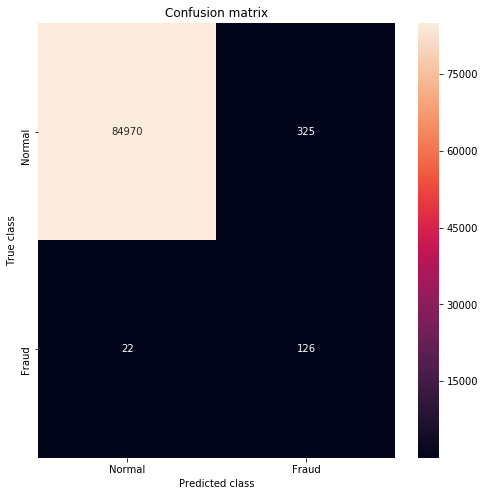

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.28      0.85      0.42       148

    accuracy                           1.00     85443
   macro avg       0.64      0.92      0.71     85443
weighted avg       1.00      1.00      1.00     85443



In [26]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se obtiene un buen recall de 0.85 para la clase 2 y se observa que hay pocos falsos positivos de la clase 1, 325 de 85,295 muestras.

# Estrategia: Ensamble de Modelos con Balanceo
# 5 Ensemble balanceado

Para esta estrategia se utilizará un Clasificador de Ensamble que emplea Bagging y un modelo de DecisionTree.

In [27]:
#Create an object of the classifier.
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Train the classifier.
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

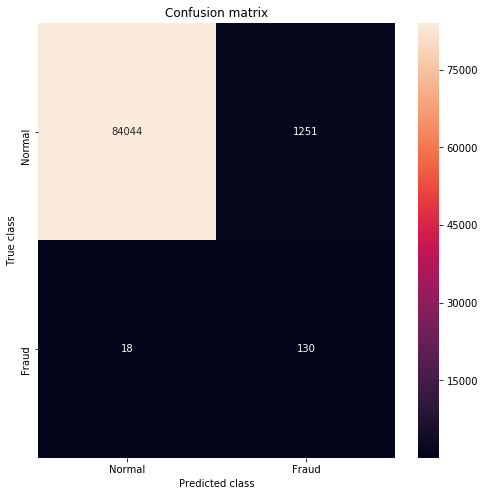

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.09      0.88      0.17       148

    accuracy                           0.99     85443
   macro avg       0.55      0.93      0.58     85443
weighted avg       1.00      0.99      0.99     85443



In [28]:
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

Se evaluará su rendimiento y se observa una mejora en comparación con el modelo inicial, con un recall de 0.88 para los casos de fraude.

# Resultados

En cuanto a los resultados obtenidos, se presentan en una tabla ordenada de mejor a peor. 

In [30]:
df = pd.DataFrame({'algorithm' : ['Regresion Logística', 'Penalizacion', 'NearMiss Subsampling', 
                                  'Random Oversampling', 'Smote Tomek', 'Ensemble'],
                   'precision' : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                   'recall' : [0.66, 0.93, 0.93, 0.89, 0.85, 0.88]})

df['overall'] = df.apply(lambda row: (row.precision + row.recall)/2, axis=1)

df = df.sort_values(['overall'], ascending=False)
df

,algorithm,precision,recall,overall
1,Penalizacion,1.0,0.93,0.965
2,NearMiss Subsampling,1.0,0.93,0.965
3,Random Oversampling,1.0,0.89,0.945
5,Ensemble,1.0,0.88,0.940
4,Smote Tomek,1.0,0.85,0.925
0,Regresion Logística,1.0,0.66,0.830


En este caso, las estrategias de Penalización y Subsampling obtienen el mejor resultado, con un recall de 0.93 cada una. Sin embargo, es importante destacar que todas las técnicas aplicadas logran mejorar el modelo inicial de Regresión Logística, que solo alcanzaba un 0.66 de recall para la clase de Fraude. Cabe recordar que el conjunto de datos presenta un desbalanceo considerable entre las clases.